# Import python libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import spearmanr
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Import data

In [39]:
df = pd.read_excel('Synthetic_data_CS_mechanical_properties.xlsx')
new_column_order = ['TKFSystem_TKF 1000','deposited_thickness_mm', 'Gas_temperature_C', 'powder_feed_rate_g_per_hr', 
                   'HIP_No','vacuum_level_mbar','particle_mean_velocity_m_s','O','N','C','Fe','O_equiv_formula','Porosity','DE',
                    'elongation_perc','UTS_mpa', 'yield_strength_mpa'] 
df = df[new_column_order]

# Data analysis and definition of dataset configuration 

## Pearson correlation

In [40]:
corr = df.corr()
yield_correlation_values_pearson = corr.loc["yield_strength_mpa"].tolist()

## Kendall correlation

In [41]:
kendall_corr_matrix = df.corr(method='kendall')
yield_correlation_values_kendall = kendall_corr_matrix.loc["yield_strength_mpa"].tolist()

## Spearman correlation

In [42]:
spearman_corr_matrix, _ = spearmanr(df)
spearman_corr_df = pd.DataFrame(spearman_corr_matrix, columns=df.columns, index=df.columns)
yield_correlation_values_spearman = spearman_corr_df.loc["yield_strength_mpa"].tolist()

## Parameter ranking

In [43]:
row_labels = ['TKFSystem_TKF 1000','deposited_thickness_mm', 'Gas_temperature_C', 'powder_feed_rate_g_per_hr', 
                   'HIP_No','vacuum_level_mbar','particle_mean_velocity_m_s','O','N','C','Fe','O_equiv_formula','Porosity','DE',
                    'elongation_perc','UTS_mpa', 'yield_strength_mpa']
column_labels = ['Pearson', 'Kendall', 'Spearman']
df_ranking = pd.DataFrame(
    data={'Pearson': yield_correlation_values_pearson, 'Kendall': yield_correlation_values_kendall,
          'Spearman': yield_correlation_values_spearman},
    index=row_labels,
    columns=column_labels
)
df_ranking['average_absolute_correlation'] = df_ranking.abs().mean(axis=1)
df_ranking_order = df_ranking.sort_values(by='average_absolute_correlation', ascending=False)
index_values_to_delete = ['yield_strength_mpa','UTS_mpa']
df_ranking_order_input = df_ranking_order.drop(index=index_values_to_delete, errors='ignore')

## Data binning

In [44]:
data= df

min_list = []
max_list = []
col_list = []

# loop through each column and get the min and max values
for col in data.columns:
    min_list.append(data[col].min())
    max_list.append(data[col].max())
    col_list.append(col)

#Create bins for yield strength
bins = [1200,1300, 1400, 1500,1600]
data['Bins'] = pd.cut(data['yield_strength_mpa'], bins=bins, include_lowest=True, labels=False)

## Split data in input & output and training & testing

In [45]:
data = data.reset_index().drop('index', axis=1)
split = StratifiedShuffleSplit (n_splits=1, test_size = 0.15, random_state =42)
for train_index, test_index in split.split(data,data['Bins']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
X_train = strat_train_set[['TKFSystem_TKF 1000','deposited_thickness_mm','Gas_temperature_C',
                          'powder_feed_rate_g_per_hr','HIP_No', 'vacuum_level_mbar',
                          'particle_mean_velocity_m_s','O','N','C','Fe','O_equiv_formula',
                          'Porosity','DE','elongation_perc']]
y_train = strat_train_set[['yield_strength_mpa']]

X_test = strat_test_set[['TKFSystem_TKF 1000','deposited_thickness_mm','Gas_temperature_C',
                          'powder_feed_rate_g_per_hr','HIP_No', 'vacuum_level_mbar',
                          'particle_mean_velocity_m_s','O','N','C','Fe','O_equiv_formula',
                          'Porosity','DE','elongation_perc']]
y_test = strat_test_set[['yield_strength_mpa']]

## Create dataset configurations based on parameter rankings

In [46]:
index_names = df_ranking_order_input.index

# Training dataset configurations
sub_dataframes_X_train = [X_train[list(index_names[:i+1])] for i in range(len(index_names))]

for i, sub_df in enumerate(sub_dataframes_X_train):
    print(f"Sub-DataFrame {i + 1} Info:")
    sub_df.info()
    print("\n")

# Test dataset configurations
sub_dataframes_X_test = [X_test[list(index_names[:i+1])] for i in range(len(index_names))]

for i, sub_df in enumerate(sub_dataframes_X_test):
    print(f"Sub-DataFrame {i + 1} Info:")
    sub_df.info()
    print("\n")

Sub-DataFrame 1 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2 to 3
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   HIP_No  22 non-null     bool 
dtypes: bool(1)
memory usage: 198.0 bytes


Sub-DataFrame 2 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2 to 3
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   HIP_No              22 non-null     bool 
 1   TKFSystem_TKF 1000  22 non-null     bool 
dtypes: bool(2)
memory usage: 220.0 bytes


Sub-DataFrame 3 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2 to 3
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HIP_No              22 non-null     bool   
 1   TKFSystem_TKF 1000  22 non-null     bool   
 2   Gas_temperature_C   22 non-null     float64
dtypes: bool(2), flo

# Training and evaluation of Polynomial regression machine learning algorithm

## Graph settings

In [47]:
# predicted value 100 % smaller than real value
a = 10
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle = math.degrees(result)

# predicted value 50 % smaller than real value

a = 7.5
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_50_smaller = math.degrees(result)

# predicted value 50 % bigger than real value

a = 5
b = 7.5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_50_bigger = math.degrees(result)

# predicted value 25 % smaller than real value

a = 6.75
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_25_smaller = math.degrees(result)

# predicted value 25 % bigger than real value

a = 5
b = 6.75
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_25_bigger = math.degrees(result)

# predicted value 10 % smaller than real value

a = 5.5
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_10_smaller = math.degrees(result)

# predicted value 10 % bigger than real value

a = 5
b = 5.5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_10_bigger = math.degrees(result)

# predicted value 5 % smaller than real value

a = 5.25
b = 5
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_5_smaller = math.degrees(result)

# predicted value 5 % bigger than real value

a = 5
b = 5.25
x = a / math.sqrt(a**2 + b**2)
result = math.asin(x)
angle_5_bigger = math.degrees(result)

## Hyperparameter optimisation

In [48]:
hyperparameters = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5,6,7,8,9,10]
}
list_degree_pr =[]
list_val_error_pr =[]
list_dataset_nr=[]

for i in range (0, len(sub_dataframes_X_train)):
    poly_reg = make_pipeline(PolynomialFeatures(), LinearRegression())
    grid_search = GridSearchCV(poly_reg, hyperparameters,cv=5,n_jobs=-1, scoring='neg_mean_squared_error',return_train_score =True)
    grid_search.fit(sub_dataframes_X_train[i],y_train.values.ravel())
    best_poly_reg_model = grid_search.best_estimator_
    cvres= grid_search.cv_results_
    list_degree =[]
    list_val_error =[]
    list_dataset =[]
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        list_degree.append(params['polynomialfeatures__degree'])
        list_val_error.append(np.sqrt(-mean_score))
        list_dataset.append(i)
    list_degree_pr.append(list_degree)
    list_val_error_pr.append(list_val_error)
    list_dataset_nr.append(list_dataset)
list_degree_pr_fl= [item for sublist in list_degree_pr  for item in sublist]
list_val_error_pr_fl = [item for sublist in list_val_error_pr  for item in sublist]
list_dataset_nr_pr_fl = [item for sublist in list_dataset_nr for item in sublist]

df_PR_grid_search_d ={
    'Dataset': list_dataset_nr_pr_fl,
    'polynomialfeatures__degree':list_degree_pr_fl,
    'RMSE': list_val_error_pr_fl,
}

df_PR_grid_search = pd.DataFrame(df_PR_grid_search_d)
min_index = df_PR_grid_search['RMSE'].idxmin()
best_dataset = df_PR_grid_search.loc[min_index, 'Dataset']
best_degree = df_PR_grid_search.loc[min_index, 'polynomialfeatures__degree']
best_result = df_PR_grid_search.loc[min_index, 'RMSE']
print("best dataset: {} / degree: {} / RESULT: {}".format(best_dataset,best_degree,best_result))

best dataset: 6 / degree: 1 / RESULT: 63.17050106471795


## Evaluation of optimal model

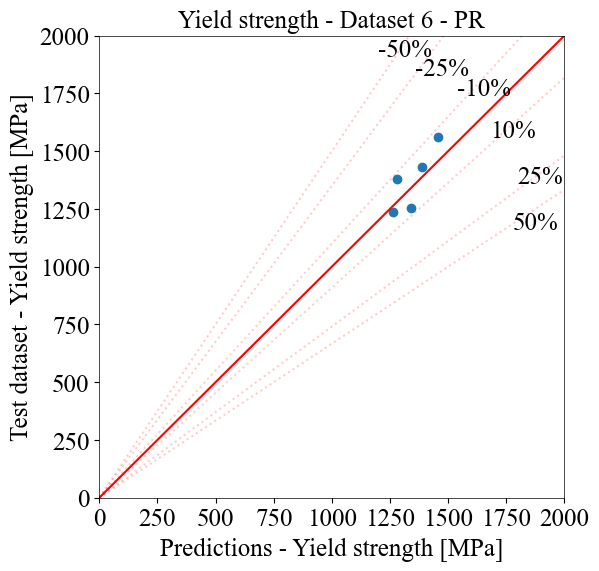

In [49]:
# Train model with optimal hyperparameters
min_index = df_PR_grid_search['RMSE'].idxmin()
best_dataset = df_PR_grid_search.loc[min_index, 'Dataset']
best_degree = df_PR_grid_search.loc[min_index, 'polynomialfeatures__degree']
best_result = df_PR_grid_search.loc[min_index, 'RMSE']
pr_opt = make_pipeline(PolynomialFeatures(degree=best_degree), LinearRegression())
pr_opt.fit(sub_dataframes_X_train[best_dataset], y_train.values.ravel())

# Let optimal model make predictions on test dataset
test_set_predictions = pr_opt.predict(sub_dataframes_X_test[best_dataset])
test_set_predictions_list=test_set_predictions.tolist()

# create plot (predict vs. real)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
fig = plt.figure(figsize=(6, 6), facecolor='white')
plt.scatter(test_set_predictions_list, y_test)

xmin, xmax = plt.xlim(0,2000)
ymin, ymax = plt.ylim(0,2000)
xmin_ymin = min(xmin, ymin)
xmax_ymax = max(xmax, ymax)
line_coords = np.arange(xmin_ymin, xmax_ymax, 0.1)
plt.plot(line_coords, line_coords, color='red')

angle_deg = angle_50_smaller
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('-50%', xy=(1200, 1910), color='black',fontsize=18)

angle_deg = angle_50_bigger
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('50%', xy=(1780, 1160), color='black',fontsize=18)

angle_deg = angle_25_smaller
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('-25%', xy=(1360, 1830), color='black',fontsize=18)

angle_deg = angle_25_bigger
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('25%', xy=(1800, 1360), color='black',fontsize=18)

angle_deg = angle_10_smaller
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('-10%', xy=(1540, 1740), color='black',fontsize=18)

angle_deg = angle_10_bigger
angle_rad = np.radians(angle_deg)
y_coords = line_coords * np.tan(angle_rad)
plt.plot(line_coords, y_coords, color='red', linestyle='dotted', alpha=0.2)
plt.annotate('10%', xy=(1680, 1560), color='black',fontsize=18)

plt.xlabel('Predictions - Yield strength [MPa]',fontsize=18)
plt.ylabel('Test dataset - Yield strength [MPa]',fontsize=18)
plt.title('Yield strength - Dataset {} - PR'.format(best_dataset) ,fontsize=18)

plt.grid(False)
fig.gca().set_facecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()